In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open('game_node_ids.json', 'r') as f:
  game_node_ids = set(json.load(f))

with open('user_node_ids.json', 'r') as f:
  user_node_ids = set(json.load(f))

with open('edges_details_by_review_id.json', 'r') as f:
  edges_details_by_review_id = json.load(f)

with open('edges_review_id_user_id_pairs_by_game_id.json', 'r') as f:
  edges_review_id_user_id_pairs_by_game_id = json.load(f)

with open('edges_review_id_game_id_pairs_by_user_id.json', 'r') as f:
  edges_review_id_game_id_pairs_by_user_id = json.load(f)

In [3]:
num_game_nodes = len(game_node_ids)
num_user_nodes = len(user_node_ids)
num_edges = len(edges_details_by_review_id)

print(f'Number of game nodes: {num_game_nodes}')
print(f'Number of user nodes: {num_user_nodes}')
print(f'Total number of nodes: {num_game_nodes + num_user_nodes}')
print(f'Number of edges: {num_edges}')

Number of game nodes: 13683
Number of user nodes: 10978890
Total number of nodes: 10992573
Number of edges: 18421343


# Node degrees

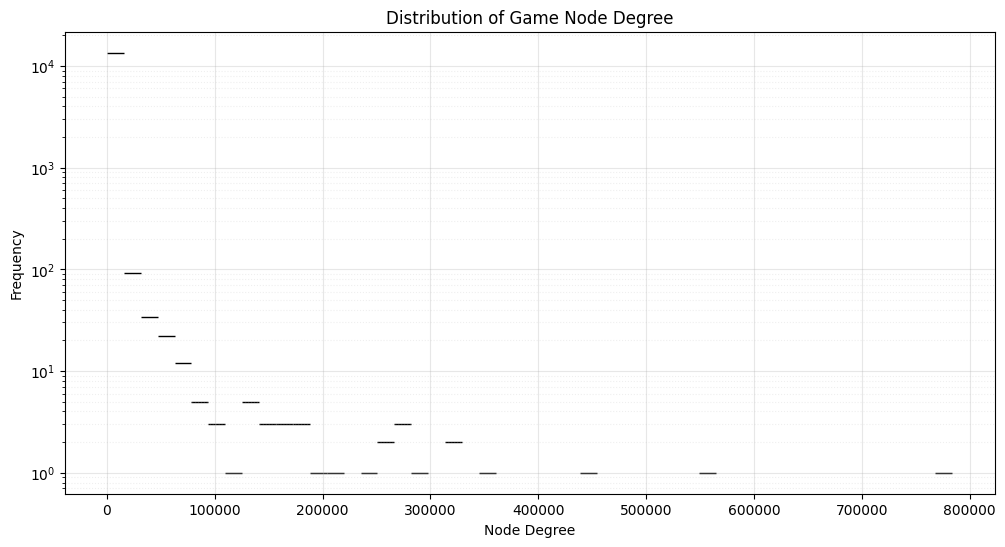

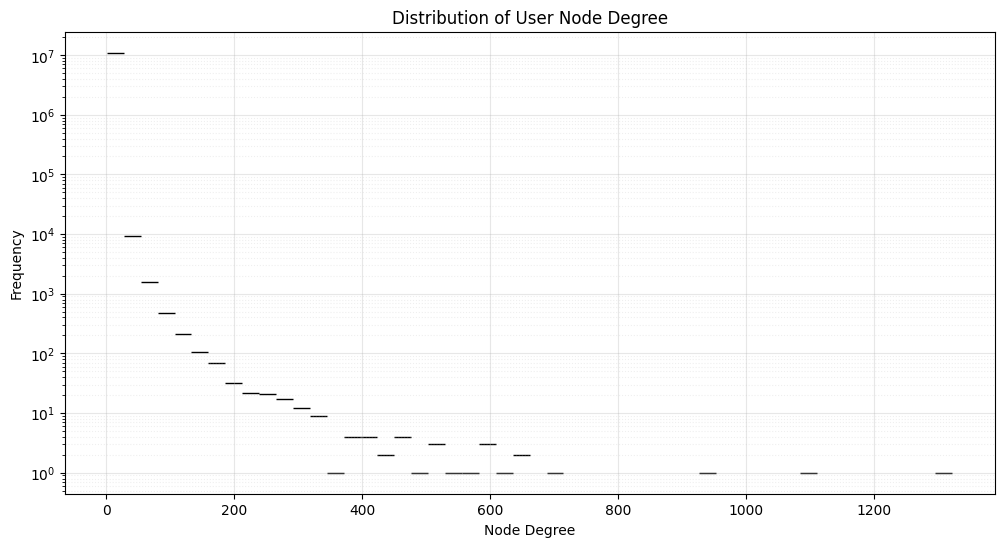

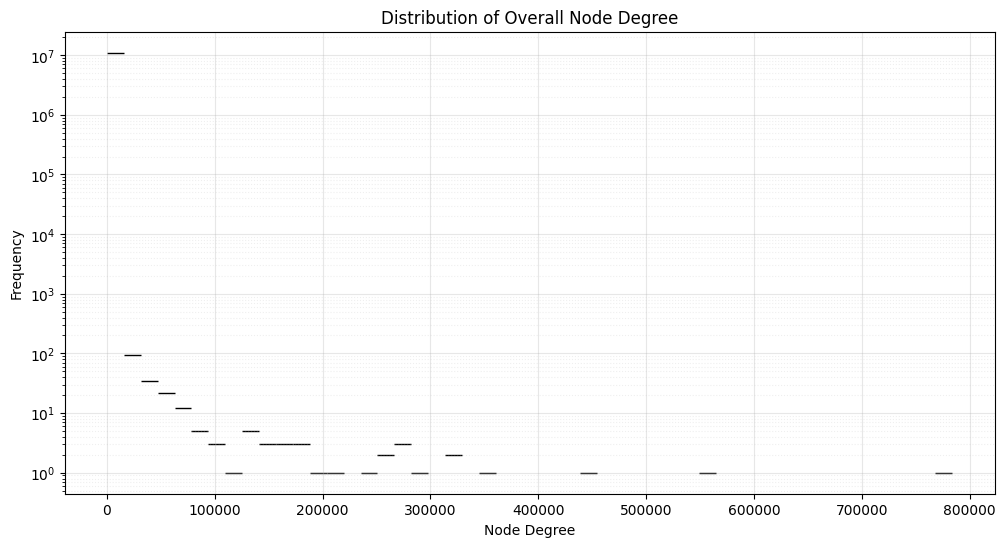

In [10]:
from matplotlib.ticker import LogLocator, MultipleLocator

def set_grid_lines():
  plt.grid(True, which="major", ls="-", alpha=0.3)
  plt.grid(True, which="minor", ls=":", alpha=0.2)
  plt.gca().yaxis.set_major_locator(LogLocator(base=10, numticks=15))
  plt.gca().yaxis.set_minor_locator(
      LogLocator(base=10, subs=range(2, 10), numticks=100))

# edges_review_id_user_id_pairs_by_game_id: dict[int, set[tuple[int, int]]]
# Calculate the number of edges for each game
game_degrees = [len(edges) for edges in edges_review_id_user_id_pairs_by_game_id.values()]

# Calculate the number of edges for each user
user_degrees = [len(edges) for edges in edges_review_id_game_id_pairs_by_user_id.values()]

# Plotting the distribution of game degrees
plt.figure(figsize=(12, 6))
sns.histplot(game_degrees, bins=50, kde=False, log_scale=(False, True))
plt.title('Distribution of Game Node Degree')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
set_grid_lines()
plt.show()

# Plotting the distribution of user degrees
plt.figure(figsize=(12, 6))
sns.histplot(user_degrees, bins=50, kde=False,
             log_scale=(False, True))
plt.title('Distribution of User Node Degree')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
set_grid_lines()
plt.show()

# Combine game and user degrees for overall node degree distribution
all_degrees = game_degrees + user_degrees

# Plotting the overall node degree distribution
plt.figure(figsize=(12, 6))
sns.histplot(all_degrees, bins=50, kde=False,
             log_scale=(False, True))
plt.title('Distribution of Overall Node Degree')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
set_grid_lines()
plt.show()

# Lorenz curve (distribution) of game node degrees

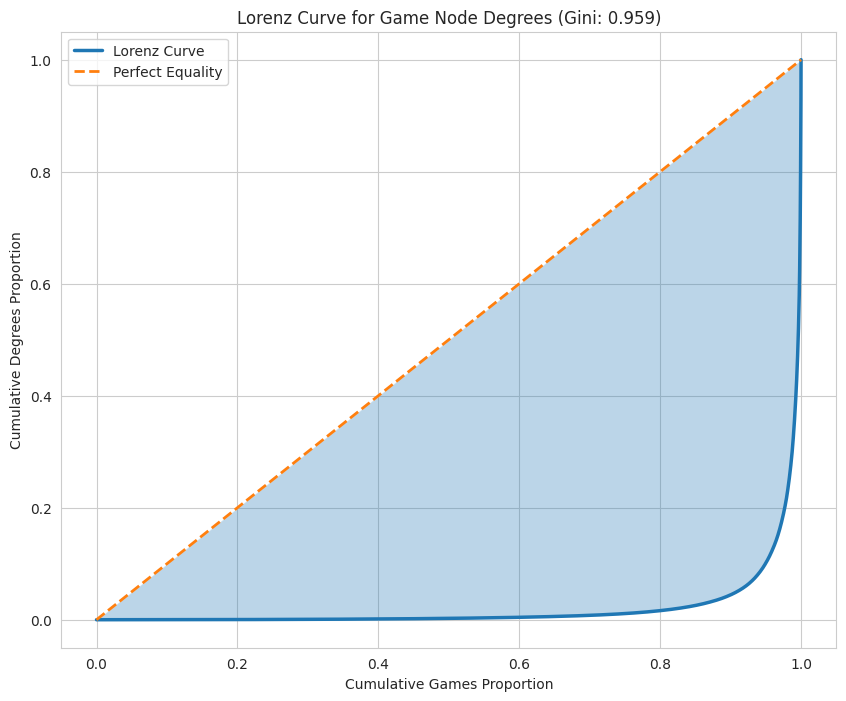

np.float64(0.9585052081383609)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import integrate


def plot_lorenz_curve_simple(incomes, title="Lorenz Curve"):
    # Sort incomes
    sorted_incomes = np.sort(incomes)
    n = len(sorted_incomes)

    # Calculate cumulative proportions
    cumsum_income = np.cumsum(sorted_incomes)
    p = np.arange(1, n + 1) / n
    L = cumsum_income / cumsum_income[-1]

    # Add origin
    p = np.insert(p, 0, 0)
    L = np.insert(L, 0, 0)

    # Calculate Gini coefficient
    gini = 1 - 2 * integrate.trapezoid(L, p)

    # Plot with seaborn style
    plt.figure(figsize=(10, 8))
    sns.set_style("whitegrid")

    plt.plot(p, L, linewidth=2.5, label='Lorenz Curve')
    plt.plot([0, 1], [0, 1], '--', linewidth=2, label='Perfect Equality')
    plt.fill_between(p, p, L, alpha=0.3)

    plt.xlabel('Cumulative Games Proportion')
    plt.ylabel('Cumulative Degrees Proportion')
    plt.title(f'{title} (Gini: {gini:.3f})')
    plt.legend()
    plt.show()

    return gini


# Example usage
np.random.seed(42)
# incomes = np.random.lognormal(10, 1, 1000)
plot_lorenz_curve_simple(game_degrees, title="Lorenz Curve for Game Node Degrees")

# Graph components count

In [14]:
from collections import defaultdict, deque

game_component_by_game_id = {}
user_component_by_user_id = {}

game_ids_by_component = defaultdict(set)
user_ids_by_component = defaultdict(set)
component_node_count = defaultdict(int)

def count_and_tag_components():
  visited_games = set()
  visited_users = set()
  current_component = 0

  def bfs(start_node: tuple[bool, int]):
    queue = deque([start_node])
    
    while queue:
      is_game_node, node = queue.popleft()

      if is_game_node:
        if node in visited_games:
          continue
        # print(f"Visiting Game {node} in Component {current_component}...")
        visited_games.add(node)
        game_component_by_game_id[node] = current_component
        game_ids_by_component[current_component].add(node)
        component_node_count[current_component] += 1

        for review_id, user_id in edges_review_id_user_id_pairs_by_game_id.get(str(node), []):
          if user_id not in visited_users:
            queue.append((False, user_id))
      else:  # is_user_node
        if node in visited_users:
          continue
        # print(f"Visiting User {node} in Component {current_component}...")
        visited_users.add(node)
        user_component_by_user_id[node] = current_component
        user_ids_by_component[current_component].add(node)
        component_node_count[current_component] += 1

        for review_id, game_id in edges_review_id_game_id_pairs_by_user_id.get(str(node), []):
          if game_id not in visited_games:
            queue.append((True, game_id))

  for game_id in game_node_ids:
    if game_id not in visited_games:
      print("New component...")
      bfs((True, game_id))
      current_component += 1

print("Counting and tagging components...")
count_and_tag_components()

print(f"Total components found: {len(game_ids_by_component.keys())}")
for component, count in component_node_count.items():
    print(f"Component {component}: {count} nodes")

Counting and tagging components...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component...
New component

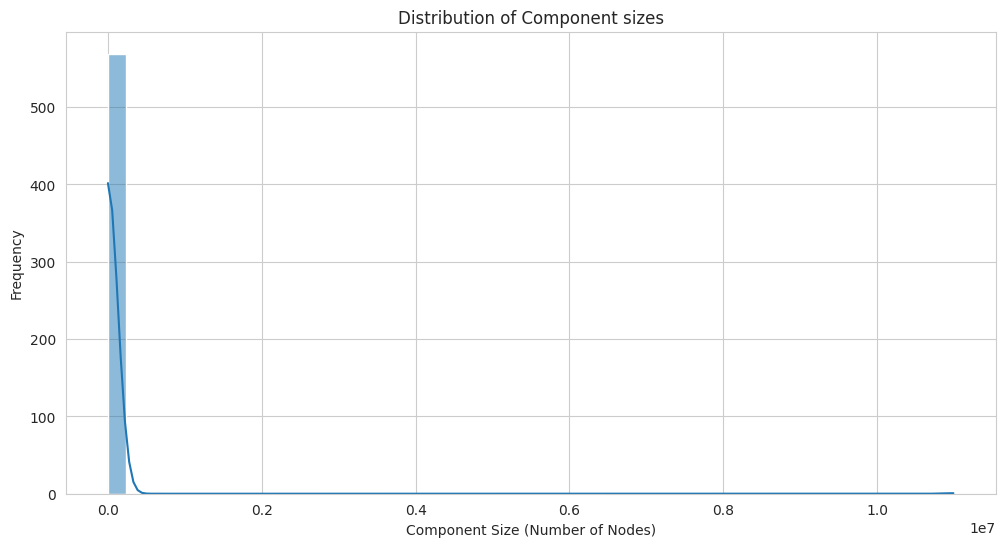

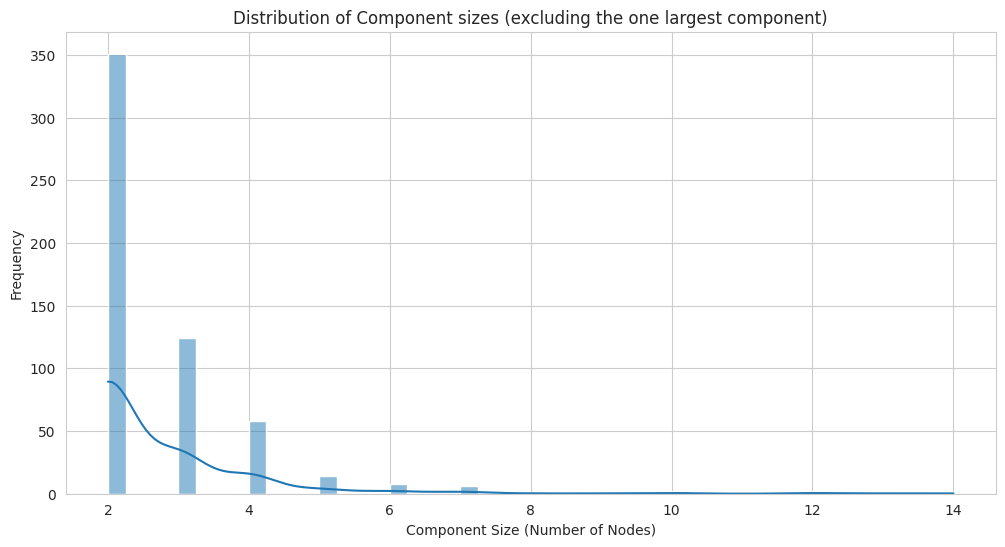

In [19]:
plt.figure(figsize=(12, 6))
# , log_scale=(False, True))
sns.histplot(
    [count for component, count in component_node_count.items()], kde=True)
plt.title('Distribution of Component sizes')
plt.xlabel('Component Size (Number of Nodes)')
plt.ylabel('Frequency')

plt.show()

plt.figure(figsize=(12, 6))
# , log_scale=(False, True))
sns.histplot([count for component, count in component_node_count.items()][1:], kde=True)
plt.title('Distribution of Component sizes (excluding the one largest component)')
plt.xlabel('Component Size (Number of Nodes)')
plt.ylabel('Frequency')

plt.show()

In [20]:
with open('game_component_by_game_id.json', 'w') as f:
  json.dump(game_component_by_game_id, f)

with open('user_component_by_user_id.json', 'w') as f:
  json.dump(user_component_by_user_id, f)

game_ids_by_component_serializable = {
    k: list(v) for k, v in game_ids_by_component.items()}
with open('game_ids_by_component.json', 'w') as f:
  json.dump(game_ids_by_component_serializable, f)

user_ids_by_component_serializable = {
    k: list(v) for k, v in user_ids_by_component.items()}
with open('user_ids_by_component.json', 'w') as f:
  json.dump(user_ids_by_component_serializable, f)

with open('component_node_count.json', 'w') as f:
  json.dump(component_node_count, f)